## Table of Contents
###  [Data Assimilation](Data Assimilation.ipynb)
<div class="toc" style="margin-top: 1em;">
   <ul class="toc-item" id="toc-level0">
      <li><span><a href='#Step 1' data-toc-modified-id="part 1"><span class="toc-item-num">&nbsp;&nbsp;</span>1. Data preparation </a></span></li>
      <li><span><a href='#Step 2' data-toc-modified-id="part 2"><span class="toc-item-num">&nbsp;&nbsp;</span>2. Configure data assimilation</a></span></li>
      <li><span><a href='#Step 3' data-toc-modified-id="part 3"><span class="toc-item-num">&nbsp;&nbsp;</span>3. Configure PFLOTRAN </a></span></li>
      <li><span><a href='#Step 4' data-toc-modified-id="part 4"><span class="toc-item-num">&nbsp;&nbsp;</span>4. Submit job on cluster </a></span></li>
      <li><span><a href='#Step 5' data-toc-modified-id="part 4"><span class="toc-item-num">&nbsp;&nbsp;</span>5. Results </a></span></li>
    
</div>






# Illustration of applying the data assimilation workflow in real case
This notebook will illustate how to estimate the hydrologic exchange flow (HEF) between surface water and groundwater by using data assimilation technique. At the Hanford 300A field site in southwestern Washington State near Columbia river, one thermistor is installed with four temperature sensors located at the depth +0.16 m, -0.04 m, -0.24 m and -0.64 m, respectively, where the origin point is at the interface between river and the sediments. Hydraulic heads are meansured at different depth in the riverbed. 

![Image](./misc/thermistor_config.png)


Two approaches are developed according to the availablity of hydraulic head measurements. If hydraulic heads are measured at the locations where the top and bottom thermistors are deployed, the key question is how to estimate the permeability of the alluvium riverbed. Once permeability is known, HEF can be calcualted according to Darcy's law. If hydraulic heads are not measured, the question is how to estimate the flux directly from the tempreature observation at a small time interval seuqnentially over time. 

In this study, an ensemble-based data assimilation method, ensemble smoother-multiple data assimilation(ES-MDA), is applied to calculate the time-invariant permeability if hydraulic heads are known or flux if hydraulic heads are unkown by assimilating observed temperatures. The advantage of ES-MDA is low computational cost and comparable perfomance to classic ensemble kalman filter (EnKF). The workflow to estimate permeability and thermal conductivity is given below and the workflow to estimate HEF directly is similar.

![Image](./misc/flowchart.png)

# Step 1. Data preparation
The minimum requirement for data to estimate flux are,

* Temperatures recorded by thermistros from three different depths (referred to as $T_{top}$ , $T_{mid}$ and $T_{bot}$ from top to bottom) 
* Distance between each two thermistors

Optional data include:

* Hydraulic head information at the locations of top and bottom thermistors (referred to as $H_{top}$ and $H_{bot}$, respectively)
* More temperature records other than the three

$T_{mid}$ is considered as temperature observation in ES-MDA. The observation data is put in obs_data.dat (./observation/obs_data.dat).<br/>   
The format for obs_data.dat is, 

|time(sec)|temperature(C) |
|:-:|:-:|
| 0    | 5.34 |  
| 300 | 5.347131 |   
| 600 | 5.360527 |
| 900 | 5.376502 |
|1200 | 5.392111 |
|1500 | 5.405733 |
|1800 | 5.41676 |
|2100 | 5.42516 |
| ...  |   ...   |

Header is included in the first line. Note that if there are more than one temperature records between the top and bottom thermistors, the data are appeneded column-wise.

$T_{top}$ and $T_{bot}$ in addition with $H_{top}$ and $H_{bot}$ if available are used as boundary conditions to drive the 1D forward model in ES-MDA. Those data are put in 'temp_top.dat', 'temp_bottom.dat', 'head_top.dat' and 'head_bottom.dat',respectively, in the directory './pflotran_inputs'. The formats of 'temp_top.dat' and 'temp_bottom.dat' are similar to that of 'obs_data.dat' except that a '#' is at the begining of the header in 'temp_top.dat' and 'temp_bottom.dat' to match PFLOTRAN's format because those two files will be directly read by PFLOTRAN. 

The raw temperature data will be first processed to generate the boundary condition files and temperature observation file with the above format. 

In [12]:
%%writefile hef.py

import numpy as np 
import pandas as pd
from src.da_methods import *
from src.pkg import *
from src.util import *
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta



Overwriting hef.py


In [77]:
# Choose thermistor 
download_date = '050119'
rodID = 509
logger_name = 'E'
use_filtered_temperature = False
therm_loc = ['5cm','10cm','15cm'] # At least three, the top and bottom thermistors will serve as the boundary condition
data_resolution = 60 # in seconds
#--------------------------------------------------------------------------
print("Start reading temperature data...")
if use_filtered_temperature:
    file = './thermistor_data/'+download_date+'_processed/'+'temperature_rod{}_logger{}_filtered.csv'.format(rodID,logger_name)
else:
    file = './thermistor_data/'+download_date+'_processed/'+'temperature_rod{}_logger{}_raw.csv'.format(rodID,logger_name)

data = pd.read_csv(file,delimiter=',')
top_bound = np.concatenate((np.arange(0,data_resolution*data.shape[0],data_resolution).reshape(-1,1),data[therm_loc[0]].values.reshape(-1,1)),axis=1)
bot_bound = np.concatenate((np.arange(0,data_resolution*data.shape[0],data_resolution).reshape(-1,1),data[therm_loc[-1]].values.reshape(-1,1)),axis=1)
if len(therm_loc) == 3:
    temp_obs = np.concatenate((np.arange(0,data_resolution*data.shape[0],data_resolution).reshape(-1,1),data[therm_loc[1:-1]].values.reshape(-1,1)),axis=1)
else:
    temp_obs = np.concatenate((np.arange(0,data_resolution*data.shape[0],data_resolution).reshape(-1,1),np.transpose(data[therm_loc[1:-1]].values)),axis=1)

np.savetxt('./pflotran_inputs/temp_top.dat',top_bound,header='time(s) {}'.format(therm_loc[0]))
np.savetxt('./pflotran_inputs/temp_bottom.dat',bot_bound,header='time(s) {}'.format(therm_loc[-1]))
np.savetxt('./observation/obs_data.dat',temp_obs,header='time(s) {}'.format(therm_loc[1:-1]))

print("Finished processing the temperature data.")


Start reading temperature data...
Finished processing the temperature data.


# Step 2. Configure Data Assimilation  

## 2.1. ES-MDA related parameters
The ES-MDA related parameters will be configured in this section. The first to be determined is the model parameters that need to be estimated.

Case 1: hydraulic heads are known
'Permeability' needs to be chosen in the parameter da_para. Thermal conductivity and porosity can be included or not. 

Case 2: hydraulic heads are not known
'hy_grad' needs to be chosen in the parameter da_para. Thermal conductivity and porosity can be added or not. Note that for the hydro-thermal module of PFLOTRAN, the flux term cannot be directly assigned, thus the flux ensemble is replaced with the ensemble of hydraulic heads at top by multiplying the ensemble of hydraulic graidents (hy_grad) with the length of model. 

The prior distribution of selected parameters are assumed to satisfy normal distrition. The ensemble mean, variance, upper limit and lower limit need to be specified for selected parameters. Ensemble size is set to be 100. Since the 1-D hydro-thermal model is simple, only one core is needed for one realization in forward simulation. Number of iterations were set to be 4 with inflation coefficients the same and satisfying SUM(1/alpha(i)) = 1 where i is the number of iteration. Note that the inflation coefficients could be in decreasing order. Inflation coefficients for state vector is set to be 1, which could be adjusted to avoid the covariance of state vector to be too small. The standard deviation of observatin error is set to be 0.01. Larger value may lead to more iterations to converge. 

In [13]:
%%writefile -a hef.py

# Configure ES-MDA
nreaz = 100          # number of realizations
infl = 1.02          # inflation coefficient for state vector
niter = 2          # number of iterations
alpha = np.array([2,2])        # inflation coefficient for each iteration, SUM(1/alpha(i))=1 where i is the number of iteration; the coefficients could be the same or in decreasing order
da_para = ['flux', 'thermal conductivity','porosity']          # ['permeability','thermal conductivity','porosity','flux'],  'permeability' and 'flux' cannot be chosen together
da_timestep = 900 # unit: sec, data assimilation timestep

# Default mean, standard deviation, upper and lower boundaries for each variable
logperm_mean = -11          # unit: log(m2), mean of prior log(permeability)
logperm_sd = 2          # unit: log(m2), S.D. of prior log(permeability)
perm_low_bound = 1e-13          # unit: m2, lower bound of permeability
perm_up_bound = 1e-9          # unit: m2, upper bound of permeability

flux_mean = 0          # unit: m/day, mean flux
flux_sd = 0.5          # unit: m/day, standard deviation of flux
flux_low_bound = -5   # unit: m/day, lower bound of hydraulic gradient       
flux_up_bound = 5     # unit: m/day, upper bound of hydraulic gradient    

th_cond_mean = 1.5          # unit: W/(mK)-1, mean of prior thermal conductivity
th_cond_sd = 0.5          # unit: W/(mK)-1, S.D. of prior thermal conductivity
th_cond_low_bound = 0.9          # unit: W/(mK)-1, lower bound of thermal conductivity
th_cond_up_bound = 2.5          # unit: W/(mK)-1, upper bound of thermal conductivity

poro_mean = 0.3          # mean porosity
poro_sd = 0.1          # standard deviation of porosity
poro_low_bound = 0.01          # lower bound of porosity
poro_up_bound = 0.7          # upper bound of porosity


Appending to hef.py


## 2.2. Observation data related parameters
The observation time window, observavtion time step, location of observation points and observation accuracy will be set up in this section. 

Observation time window means the time window that users want to do data assimilation, which allows partial temperature data in the time window that users are interested to be used. It is specified with the observation starting time (obs_start_time) and observation ending time (obs_end_time). Note that the observation ending time cannot be larger than the maximum time in obs_data.dat. 

Observation time step is the time interval that temperatures are collected. Location of observation points are the distance of observation points to the top thermistor. Note that the minus sign is needed representing the observation points are in the downward direction. 

Observation accuracy represents the measurement error. One third of the observation accuracy will be used as the standard deviation to generate the observation error. 

In [14]:
%%writefile -a hef.py

# Configure observation 
obs_start_time = 0              # unit:s, the starting point of observation window
obs_end_time = 1203780          # unit:s, the ending point of observation window
obs_timestep = 60              # unit:s, the time interval that temperatures are collected
therm_loc = [-0.05,-0.1,-0.15] # unit:m, location of thermistor, negative means below the riverbed
obs_accuracy = 0.2              # unit: C, accuracy of temperature measurement


Appending to hef.py


# Step 3. Configure PFLOTRAN 
The forward simulator used in this case is PFLOTRAN, a massively parallel code for subsurface flow and transport modeling (https://www.pflotran.org/). The thermal-hydro module of PFLOTRAN is used in this study to simulate one-dimensional fluid and heat transport in the riverbed along the thermistor. The geometry of the numerical model is in analogue to the thermistor. A template of PFLOTRAN input file has been provided ('./pflotran_inputs/1dthermal.in'), which is aimed to make the modifications to the input file to be minimum.


The distance between the top and bottom thermistor is set to be the length of the 1D model domain. The observation timestep (obs_timestep) is set to be the time interval to export the snapshots in PFLOTRAN.  

The path to the PFLOTRAN executable file and the number of cores used for running the job are also need to be specified by users. The shell script for submitting PFLOTRAN input files on the Cori machine of NERSC is located at './src/pflotran.sh'.

In [15]:
%%writefile -a hef.py

# Configure model domain and PFLOTRAN running environment
hz = 0.1          # unit: m, height of the 1-D column
exeprg = '/global/project/projectdirs/pflotran/pflotran-cori-new/src/pflotran/pflotran'
#exeprg = '/global/u2/k/kchen89/pflotran-cori-dbase'          # path to PFLOTRAN executable file
ncore = 100          # number of cores 

#----------------------------------------------------------
kwargs1 = {}
if 'permeability' in da_para:
    kwargs1.update({'logperm_mean':logperm_mean})
    kwargs1.update({'logperm_sd':logperm_sd})
    kwargs1.update({'perm_low_bound':perm_low_bound})
    kwargs1.update({'perm_up_bound':perm_up_bound})                 

if 'flux' in da_para:
    kwargs1.update({'flux_mean':flux_mean})
    kwargs1.update({'flux_sd':flux_sd})
    kwargs1.update({'flux_low_bound':flux_low_bound})
    kwargs1.update({'flux_up_bound':flux_up_bound}) 

if 'thermal conductivity' in da_para:
    kwargs1.update({'th_cond_mean':th_cond_mean})
    kwargs1.update({'th_cond_sd':th_cond_sd})
    kwargs1.update({'th_cond_low_bound':th_cond_low_bound})
    kwargs1.update({'th_cond_up_bound':th_cond_up_bound})
    
if 'porosity' in da_para:
    kwargs1.update({'poro_mean':poro_mean})
    kwargs1.update({'poro_sd':poro_sd})
    kwargs1.update({'poro_low_bound':poro_low_bound})
    kwargs1.update({'poro_up_bound':poro_up_bound})

th1d = TH1D(da_para,nreaz,hz,**kwargs1)
if 'permeability' in da_para:
    da_time_win = np.array([[0,obs_end_time-obs_start_time]])
else:
    da_time_win = np.array([[0,da_timestep]])
    time = da_timestep 
    while time < (obs_end_time-obs_start_time):
        da_time_win = np.append(da_time_win,[[time,time+da_timestep]],axis=0)
        time = time + da_timestep
    da_time_win = da_time_win[0:-1,:]

obs_coord = np.array(therm_loc[1:-1])-np.array(therm_loc[0])
obs_data = np.loadtxt('./observation/obs_data.dat',skiprows=1)
obs_start_idx = int(obs_start_time/obs_timestep)
obs_end_idx = int(obs_end_time/obs_timestep)
obs_data = obs_data[obs_start_idx:obs_end_idx+1,:]
obs_data[:,0] = obs_data[:,0]-obs_start_time

obs = Obs(obs_start_time,obs_end_time,obs_timestep,obs_coord,obs_accuracy,obs_data)

subprocess.call("rm -rf ./pflotran_results/*.h5",stdin=None, stdout=None,stderr=None,shell=True)
subprocess.call("rm -rf ./pflotran_results/*.chk",stdin=None, stdout=None,stderr=None,shell=True)
subprocess.call("rm -rf ./pflotran_results/*.out",stdin=None, stdout=None,stderr=None,shell=True)

subprocess.call("cp ./pflotran_inputs/1dthermal.in ./pflotran_results/",stdin=None, stdout=None,stderr=None,shell=True)

kwargs2 = {"exeprg":exeprg,"ncore":ncore,"niter":niter,"alpha":alpha,"da_time_win":da_time_win}
state_vector = Assimilator(nreaz,infl,th1d,obs,**kwargs2)

Appending to hef.py


# 4. Submit job on cluster
The main program that controls the entire workflow is writen in Python('./hef.py'). The python script will be generated with the above inputs and then submitted to cluster. Following is the code to submit to 

In [55]:
%%sbatch 
#!/bin/bash -l
#SBATCH -A m1800
#SBATCH -q premium
#SBATCH -N 3
#SBATCH -t 00:30:00
#SBATCH -L SCRATCH
#SBATCH -C haswell
#SBATCH -J flux

module load python
python hef.py 
wait


u'Submitted batch job 22266409\n'

# Step 5.  Results

## 5.1. Temperature data

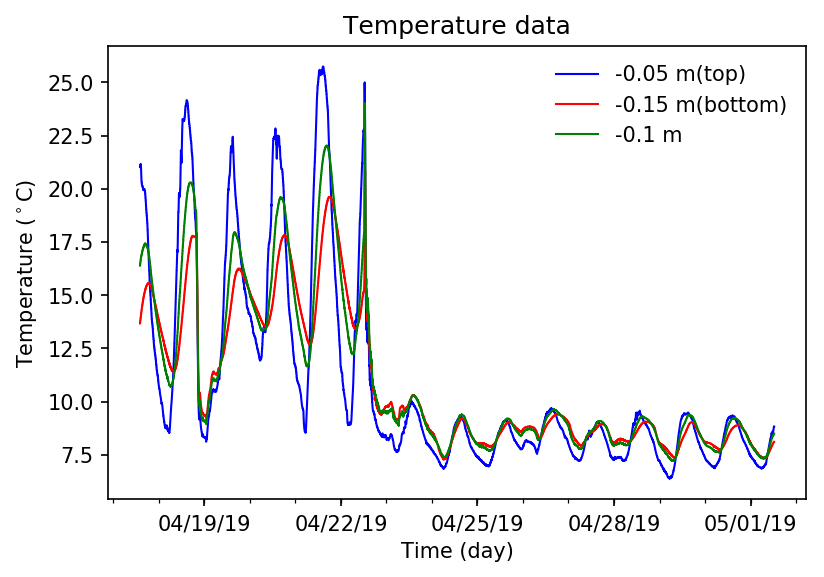

In [16]:
obs_start_time = 0
obs_end_time = 1203780
therm_loc = [-0.05,-0.1,-0.15]
init_datetime = '2019-04-17 14:03:00'   
plot_temp_data(therm_loc,obs_start_time,obs_end_time,init_datetime)


## 5.2. Estimated flux

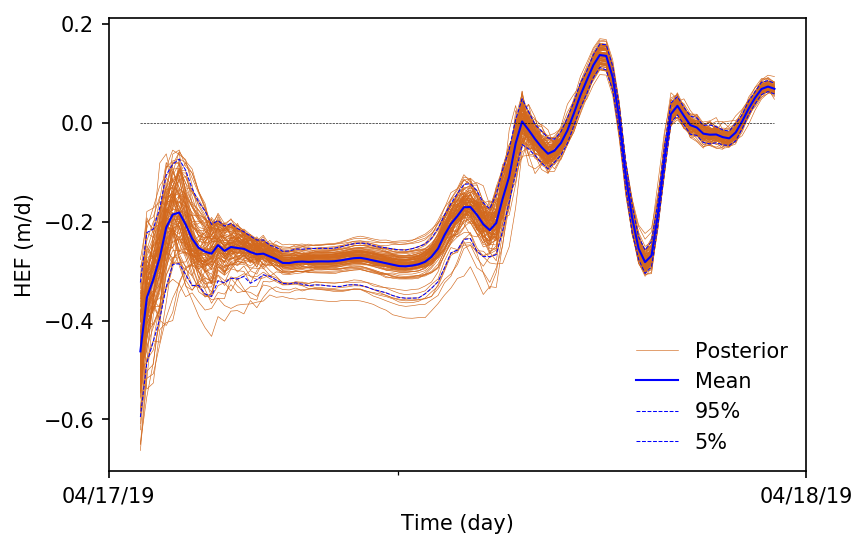

In [17]:
nreaz = 100
da_para = ['flux', 'thermal conductivity','porosity']
da_timestep = 900
obs_timestep = 60
init_datetime = '2019-04-17 14:03:00'    

plot_hef_without_head(da_para,da_timestep,obs_timestep,nreaz,init_datetime)
